- We are going to us a bidirectional LSTM to predict protein families based on their amino acid sequence
- Data is taken from the Pfam database that hosts protein domain sequences of more than 20.000 families (20,795)
- Each Protein domain will have an amino acid sequence and the ID of its protein familiy

In [1]:
import urllib.request
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

2024-04-03 17:37:46.492304: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-03 17:37:46.533394: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 17:37:46.533422: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-03 17:37:46.534666: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-03 17:37:46.541025: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-03 17:37:46.541407: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
url = "https://raw.githubusercontent.com/Tillsa/2023-10-24-input_data/main/Pfam-A-Subset_selection.csv"
protein_domains = "protein_domains.csv"
 
urllib.request.urlretrieve(url, protein_domains)



('protein_domains.csv', <http.client.HTTPMessage at 0x7fc2c94a8650>)

In [4]:
df = pd.read_csv(protein_domains, index_col=None, header=0, sep="\t")

In [5]:
df.head()

,sequence_id,family_id,short_name,sequence
0,A0A1G9LX05_9FLAO/3-180,PF01812.24,5-FTHF_cyc-lig,KKSLRSKYLKRREEMSAQELLDADLSIANNLLQLPVWKFSNYHIFL...
1,A0A429RVF1_9ACTN/1-183,PF01812.24,5-FTHF_cyc-lig,MRRELIAARRALAPGAVEAAGRELARQALALPELARAGTVAAYVSV...
2,Q0F944_9RHOB/8-182,PF01812.24,5-FTHF_cyc-lig,KSLCRKAAFKARAEAHVAGHDNKANAQLYNYLKTQDSNLVIAAYMP...
3,A0A6P3ZSC5_ZIZJJ/69-274,PF01812.24,5-FTHF_cyc-lig,KKLLRSRVRKQLKAMDPTLRSQEDDEIQRLVLEAPWFKSCQRLCAY...
4,B4QVH6_DROSI/34-232,PF01812.24,5-FTHF_cyc-lig,KRSLRVQTWKKIQEGKVGIGFNNIFNRIPSFVGADKAAALFANEEE...


In [6]:
df.shape

(391843, 4)

In [7]:
df["family_id"].value_counts()

family_id
PF03171.24    20736
PF01490.22    20661
PF13279.10    19852
PF13086.10    19747
PF00324.25    19663
PF00725.26    18207
PF13087.10    16923
PF00198.27    15268
PF03109.20    15252
PF07724.18    15141
PF12848.11    14323
PF07728.18    14290
PF19055.4     13666
PF17863.5     13509
PF13671.10    13486
PF13476.10    11828
PF12679.11    11729
PF13640.10    11647
PF02872.22    11635
PF13304.10    11075
PF00002.28    10729
PF17871.5     10646
PF00950.21    10562
PF12729.11    10387
PF02230.20    10328
PF13532.10    10292
PF13401.10    10231
PF01812.24    10030
Name: count, dtype: int64

In [8]:
df = df.groupby("family_id").apply(lambda x: x.sample(1000)

In [9]:
df["family_id"].value_counts()

family_id
PF00002.28    1000
PF00198.27    1000
PF17871.5     1000
PF17863.5     1000
PF13671.10    1000
PF13640.10    1000
PF13532.10    1000
PF13476.10    1000
PF13401.10    1000
PF13304.10    1000
PF13279.10    1000
PF13087.10    1000
PF13086.10    1000
PF12848.11    1000
PF12729.11    1000
PF12679.11    1000
PF07728.18    1000
PF07724.18    1000
PF03171.24    1000
PF03109.20    1000
PF02872.22    1000
PF02230.20    1000
PF01812.24    1000
PF01490.22    1000
PF00950.21    1000
PF00725.26    1000
PF00324.25    1000
PF19055.4     1000
Name: count, dtype: int64

In [10]:
len(df["family_id"].value_counts())

28

In [11]:
28
df.shape

(28000, 4)

In [13]:
df_red = df[["family_id", "sequence"]].reset_index(drop=True)
df_red.head()

,family_id,sequence
0,PF00002.28,AYMMFYVAVVGHSVSLLTLTSSLGVFLRFRNLACQRVTMHKHMFLT...
1,PF00002.28,ETVINVSLTLSVISVALLVAALVLFSIFDSIQCRRLQIHKNLALAF...
2,PF00002.28,LLSLYFIYTVGYALSFSALVIASAILLGFRHLHCTRNYIHLNLFAS...
3,PF00002.28,WSTEGCYLLKTNDTHTSCNCSHLSTFALLMAFTGQVLCSVIAVGLH...
4,PF00002.28,TQLPSVTLIVGCGVSSLTLLLLIIIYVSVWRYIRSERSVILINFCL...


In [15]:
aa_seq_dict = {"A": 1,
               "C": 2,
               "D": 3,
               "E": 4,
               "F": 5,
               "G": 6,
               "H": 7,
               "I": 8,
               "K": 9,
               "L": 10,
               "M": 11,
               "N": 12,
               "P": 13,
               "Q": 14,
               "R": 15,
               "S": 16,
               "T": 17,
               "V": 18,
               "W": 19,
               "Y": 20}

In [16]:
def aa_seq_encoder(data):
    full_sequence_list = []
    for sequence in data['sequence'].values:
        row_sequence_list = []
        for aa in sequence:
            row_sequence_list.append(aa_seq_dict.get(aa, 0))
        full_sequence_list.append(np.array(row_sequence_list))
    return full_sequence_list

In [17]:
features_encoded = aa_seq_encoder(df_red)

In [18]:
features_encoded[1]

array([ 4, 17, 18,  8, 12, 18, 16, 10, 17, 10, 16, 18,  8, 16, 18,  1, 10,
       10, 18,  1,  1, 10, 18, 10,  5, 16,  8,  5,  3, 16,  8, 14,  2, 15,
       15, 10, 14,  8,  7,  9, 12, 10,  1, 10,  1,  5, 18,  5, 15,  5,  1,
       18, 10,  1,  8, 19, 17, 18, 10, 12, 16, 16, 12,  1,  5,  7,  3,  2,
       12, 14, 20, 18, 13, 14, 13,  8,  9, 16, 10,  4, 19, 10,  2,  9, 11,
       18,  8, 19, 10, 18,  8, 20,  5, 14, 18,  1, 16, 18, 11, 19, 11, 10,
        8,  4,  6,  8, 20, 10, 20, 16, 15,  5, 17, 18,  5,  1, 11, 15, 20,
        6,  3,  1, 13, 20,  1, 18,  5, 10, 10, 17,  6, 19,  6,  8, 13,  5,
       18, 18, 18, 11,  8, 19, 17,  5,  8,  7, 16, 16,  8, 17, 16,  9,  8,
       13,  7, 16, 20,  2, 19, 10, 13, 20,  1, 14,  6, 15,  7, 10, 19,  8,
       10,  6,  6, 17, 11,  6,  1,  1, 10, 10, 10, 12, 10, 18, 18, 10, 10,
        1,  8,  8,  6,  8, 10, 18, 14,  9, 10, 15, 17,  4, 16,  1,  1,  4,
       16,  9,  9,  8, 19, 15,  1, 18,  9,  1, 17,  8, 10, 10, 18, 13, 10,
       10,  6, 18, 16, 12

In [19]:
print(len(features_encoded[1]))

255


In [20]:
from keras.preprocessing.sequence import pad_sequences
max_length = 100
features_padded = pad_sequences(features_encoded, maxlen=max_length, padding="post", truncating="post")

In [21]:
print(features_padded)

[[ 1 20 11 ... 10 10 10]
 [ 4 17 18 ... 18 11 19]
 [10 10 16 ...  1  1 12]
 ...
 [ 7 14 13 ...  0  0  0]
 [ 7 14 13 ... 18  1 17]
 [ 7 14 13 ...  0  0  0]]


In [22]:
print(len(features_padded[1]))

100


In [23]:
features_padded[0]

array([ 1, 20, 11, 11,  5, 20, 18,  1, 18, 18,  6,  7, 16, 18, 16, 10, 10,
       17, 10, 17, 16, 16, 10,  6, 18,  5, 10, 15,  5, 15, 12, 10,  1,  2,
       14, 15, 18, 17, 11,  7,  9,  7, 11,  5, 10, 17, 20,  8, 10, 12, 16,
        8,  6, 18, 10, 18,  7, 10, 17, 14, 18, 18, 13,  9,  8,  4, 20, 18,
       12, 16,  3, 13,  8, 16,  8,  1, 20,  9, 19, 16, 10, 18, 16, 19,  5,
       11, 19, 15,  1, 10,  8, 16, 17,  5,  1,  5, 13, 10, 10, 10],
      dtype=int32)

In [25]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels_encoded = le.fit_transform(df_red["family_id"])

In [26]:
print(labels_encoded)

[ 0  0  0 ... 27 27 27]


In [28]:
from tensorflow.keras.utils import to_categorical
labels_one_hot = to_categorical(labels_encoded)

In [29]:
# example of label 1
print(labels_one_hot[0])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [30]:
# example of label 27
print(labels_one_hot[-1])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1.]


In [32]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    features_padded, labels_one_hot, test_size=0.25, random_state=42)

In [33]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM,Dropout
from keras.layers import Embedding
from keras.models import Model

In [34]:
model = Sequential()
# Word embedding in language models gives words, 
# that have similar meanings, are used in similar contexts, or are semantically related 
# embedding vectors that are close together in the embedding space.
model.add(Embedding(21, 8, input_length=max_length))

In [35]:
model.add(Bidirectional(LSTM(8)))

In [37]:
model.add(Dropout(0.2))

In [38]:
model.add(Dense(28, activation="softmax"))

In [39]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 8)            168       
                                                                 
 bidirectional (Bidirection  (None, 16)                1088      
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 28)                476       
                                                                 
Total params: 1732 (6.77 KB)
Trainable params: 1732 (6.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [41]:
history = model.fit(train_features, train_labels,
                    epochs=20, verbose=0, validation_split=0.25)

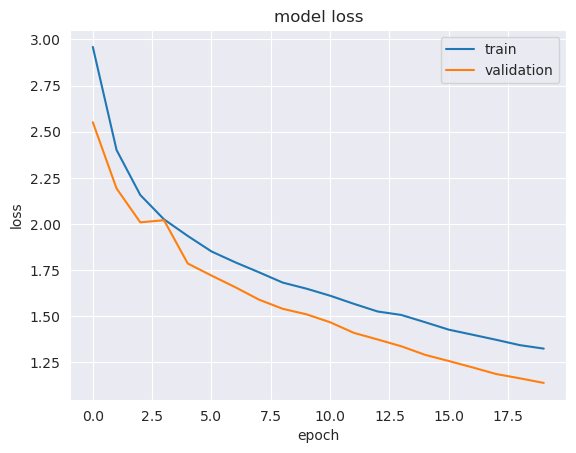

In [42]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

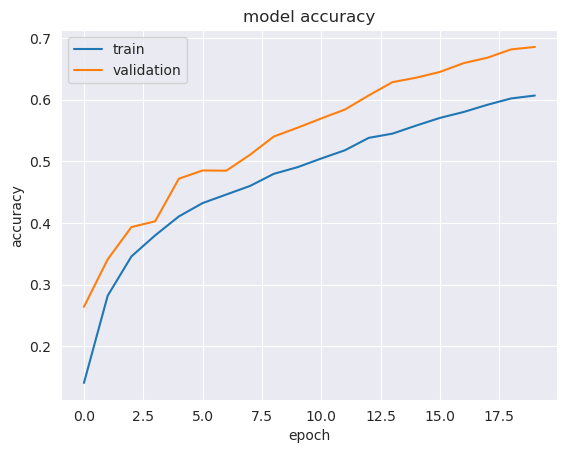

In [43]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [44]:
from sklearn.metrics import confusion_matrix
test_features_pred = model.predict(test_features)
cm = confusion_matrix(np.argmax(test_labels, axis=1), np.argmax(test_features_pred, axis=1))

219/219 [==============================] - 2s 7ms/step


<Axes: >

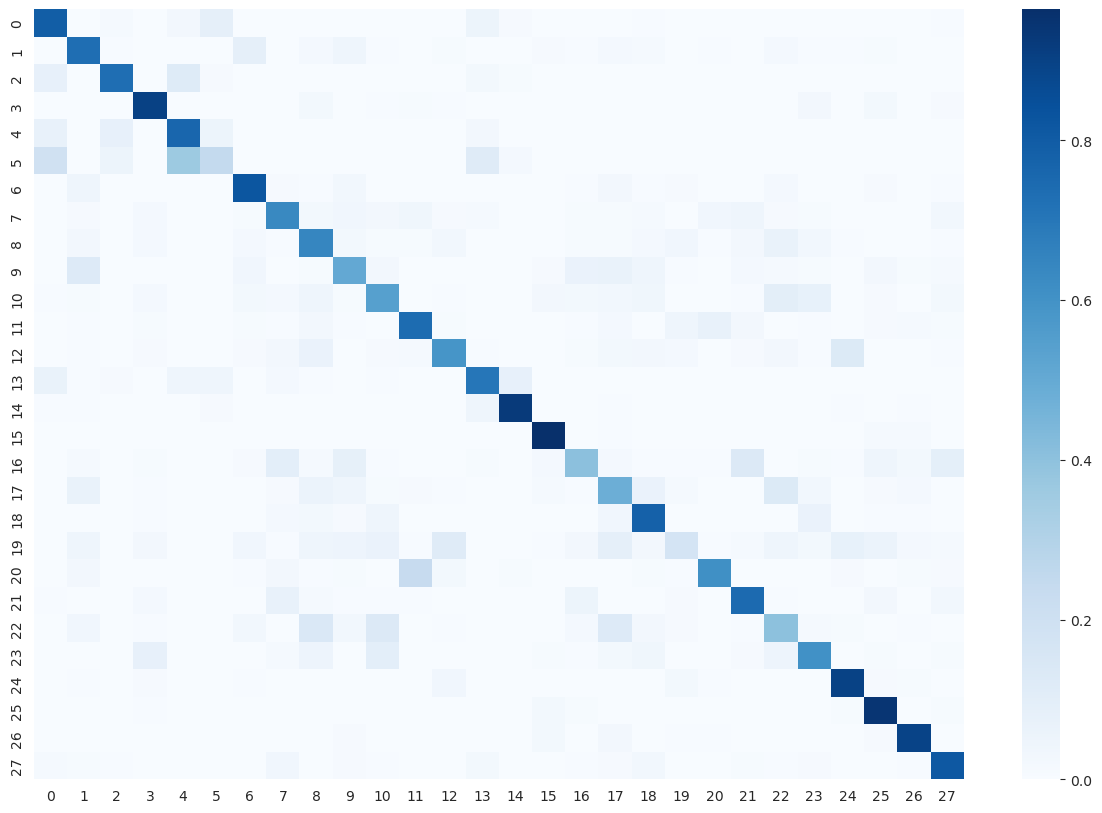

In [45]:
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
plt.figure(figsize=(15,10))
sns.heatmap(cm, annot=False, cmap="Blues")